# Concentration de CO2 dans l'atmosphère depuis 1958

M. Keeling a démarré en 1958 une série d'observations de mesures de la concentration de CO2 à Mauna Loa (Hawaii, USA). Ce jeu de données, dit "Keeling Curve", est crucial pour constater l'évolution de cette concentration au vu de la durée de l'expérience. Les données sont disponibles sur le [site de l'institut Scripps](https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html). Sur celui-ci, nous allons nous intéresser aux mesures hebdomadaires, récupérables sur [ce lien](https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv). Puisque le fichier est mis à jour toutes les semaines, nous nous baserons ici sur une copie locale de ce fichier, récupérée le 16 janvier 2024.

## Analyse de la fidélité des données

La première étape est de charger les données du fichier et de s'assurer de son contenu. D'après les commentaires en en-tête de fichier, la première colonne indique la date et la seconde la concentration de CO2 en micro-moles par mole (ppm). Les mesures sont alignées sur 12h00 sur le premier jour de la semaine.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek
import datetime

In [3]:
# Data taken from
# https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv

path = "weekly_in_situ_co2_mlo.csv"
raw_data = pd.read_csv(path, comment='"', names=["Date", "Concentration"])

Vérifions les semaines manquantes dans le dataset.

In [4]:
# Check if every line is the corresponding week
expected_date = set()
w = 0
while True:
    new_week = str(isoweek.Week(1958, 13+w).saturday())
    if new_week >= '2024-01-01':
        break
    expected_date.add(new_week)
    w += 1

# Remove line if found
for w in raw_data.index:
    stored_date = raw_data["Date"][w]
    expected_date.remove(stored_date)

missing_weeks = sorted(expected_date)
print(f"Missing weeks ({len(missing_weeks)} in total out of {w} weeks):")
print(",\t".join(missing_weeks))

missing_weeks_keep_year = [e[:4] for e in missing_weeks]
missing_weeks_per_year = dict()
for e in missing_weeks_keep_year:
    if e in missing_weeks_per_year.keys():
        missing_weeks_per_year[e] += 1
    else:
        missing_weeks_per_year[e] = 1
        
print(f"\nMissing weeks per year:")
for y in sorted(missing_weeks_per_year):
    print(y, missing_weeks_per_year[y])

Missing weeks (74 in total out of 3357 weeks):
1958-05-10,	1958-05-31,	1958-06-07,	1958-06-14,	1958-06-21,	1958-06-28,	1958-08-23,	1958-09-13,	1958-09-20,	1958-09-27,	1958-10-04,	1958-10-11,	1958-10-18,	1958-10-25,	1958-11-01,	1959-02-07,	1959-03-14,	1959-05-30,	1959-08-15,	1962-08-25,	1962-09-01,	1962-09-08,	1962-12-29,	1963-02-16,	1963-05-04,	1963-11-23,	1964-01-25,	1964-02-01,	1964-02-08,	1964-02-15,	1964-02-22,	1964-02-29,	1964-03-07,	1964-03-14,	1964-03-21,	1964-03-28,	1964-04-04,	1964-04-11,	1964-04-18,	1964-04-25,	1964-05-02,	1964-05-09,	1964-05-16,	1964-05-23,	1964-06-13,	1964-06-20,	1964-08-08,	1966-07-16,	1966-07-23,	1966-07-30,	1966-11-05,	1967-01-21,	1967-01-28,	1976-06-26,	1984-03-31,	1984-04-07,	1984-04-14,	1984-04-21,	1985-08-03,	2003-06-14,	2003-10-11,	2003-10-18,	2005-02-26,	2005-03-05,	2005-03-12,	2005-03-19,	2006-02-11,	2006-02-18,	2007-01-27,	2012-10-06,	2012-10-13,	2020-01-18,	2022-12-03,	2022-12-10

Missing weeks per year:
1958 15
1959 4
1962 4
1963 3
1964 21
1966

Nous pouvons constater que certaines années ont quelques semaines manquantes. Celles qui se démarquent le plus notamment sont 1958 et 1964 pour lesquelles une grosse part de l'année est manquante. Pour rappel, l'année 1958 n'est mesurée qu'à partir de la première donnée, ainsi les semaines maquantes sont bien des données manquantes _entre_ des mesures et non le début d'année, qui n'a pas été mesuré. Au sens global, seuls environ 2% des mesures sont manquantes, l'influence sur les résultats est donc limitée.

In [5]:
data = raw_data.copy()

data['Date'] = [pd.Period(w, 'W') for w in data['Date']]

data = data.set_index('Date').sort_index()

## Graphique de l'évolution de la concentration de CO2

Maintenant que notre dataset est vérifié, nous pouvons tracer un premier graphique concernant l'évolution de la concentration en CO2 dans l'atmosphère de Mauna Loa. Nous obtenons le graphique suivant, en nuage de points:

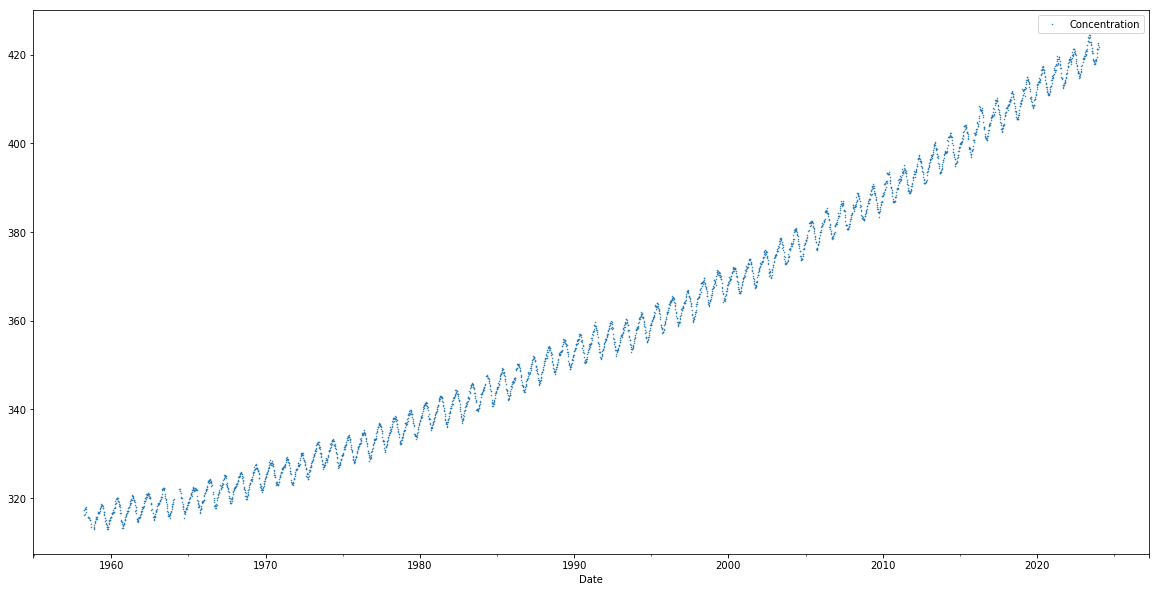

In [13]:
data.plot(figsize=(20, 10), style='.', ms=1)

Nous constatons ainsi deux phénomènes. Le premier est une tendance globale de l'augmentation de la concentration. Le second est une oscillation périodique tout au long de la courbe.

## Tendance globale

Afin de mesurer la tendance globale, puisque l'oscillation périodique observée est annuelle, nous allons calculer la moyenne annuelle de la concentration de CO2.

In [30]:
# Create an array containing the week period containing the 1st of January
# So that we get the data for each year
week_containing_march_29 = [pd.Period(pd.Timestamp(y, 1, 1), 'W')
                           for y in range(1958, 2024)]

year = []
yearly_avg = []

for week1, week2 in zip(week_containing_march_29[:-1], week_containing_march_29[1:]):
    year_data = data['Concentration'][week1:week2]
    avg = year_data.sum()/year_data.count()
    year.append(week2.year)
    yearly_avg.append(avg)

yearly_avg = pd.Series(data=yearly_avg, index=year)

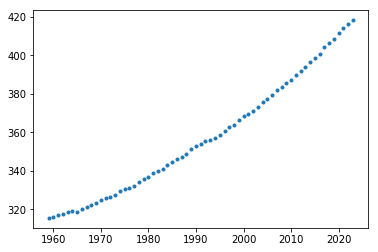

In [34]:
yearly_avg.plot(style='.')